# Computer Vision
# Jacobs University Bremen
# Fall 2021
# Homework 2
*This notebook includes both coding and written questions. Please hand in this notebook file with all the outputs and your answers to the written questions.*

This assignment covers linear filters, convolution and correlation.

In [59]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from time import time
from skimage import io

!pip install scikit-image

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 1: Convolutions
### 1.1 Commutative Property (10 points)
Recall that the convolution of an image $f:\mathbb{R}^2\rightarrow \mathbb{R}$ and a kernel $h:\mathbb{R}^2\rightarrow\mathbb{R}$ is defined as follows:
$$(f*h)[m,n]=\sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[i,j]\cdot h[m-i,n-j]$$

Or equivalently,
\begin{align}
(f*h)[m,n] &= \sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty h[i,j]\cdot f[m-i,n-j]\\
&= (h*f)[m,n]
\end{align}

Show that this is true (i.e. prove that the convolution operator is commutative: $f*h = h*f$).

**Your Answer:** *Write your solution in this markdown cell. Please write your equations in [LaTex equations](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Typesetting%20Equations.html).*

As given,

\begin{equation*}
(f * h)[m,n] =  \sum_{i=-\infty}^\infty \sum_{j=-\infty}^\infty f[i,j] \cdot h[m-i,n-j] 
\end{equation*}

First, we use a substitution that $x = m-i$ and $y = n-j$. Subsequently, $i = m-x$ and $j = n-y$ and when $i = \infty$, then $x = -\infty$ and vice versa. The same is held true for when $j = \infty$ and $y = -\infty$ and vice versa.

Using this substitution in the equation leads us to:

\begin{equation*}
(f * h)[m,n] =  \sum_{x=-\infty}^\infty     \sum_{y=-\infty}^\infty f[m-x,n-y] \cdot h[x,y] 
\end{equation*}

Although the limits change during the substitution, this is irrelevant since this is a summation.

Rewriting the equation yields:

\begin{equation*}
(f * h)[m,n] =  \sum_{x=-\infty}^\infty    \sum_{y=-\infty}^\infty h[x,y] \cdot f[m-x,n-y] = (h * f)[m,n]
\end{equation*}

Hence proved.




### 1.2 Implementation (30 points)

In this section, you will implement two versions of convolution:
- `conv_nested`
- `conv_fast`

First, run the code cell below to load the image to work with.

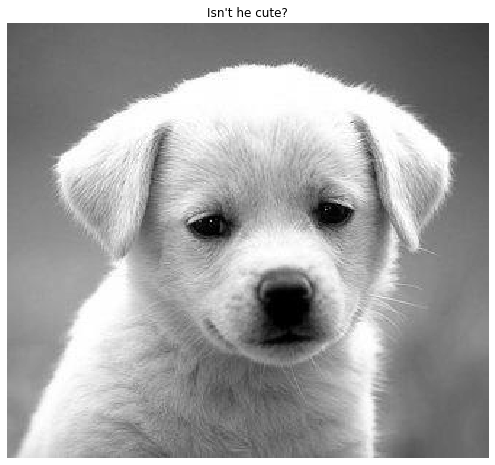

In [60]:
# Open image as grayscale
img = io.imread('dog.jpg', as_gray=True)

# Show image
plt.imshow(img)
plt.axis('off')
plt.title("Isn't he cute?")
plt.show()

Now, implement the function **`conv_nested`** in **`filters.py`**. This is a naive implementation of convolution which uses 4 nested for-loops. It takes an image $f$ and a kernel $h$ as inputs and outputs the convolved image $(f*h)$ that has the same shape as the input image. This implementation should take a few seconds to run.

*- Hint: It may be easier to implement $(h*f)$*

We'll first test your `conv_nested` function on a simple input.

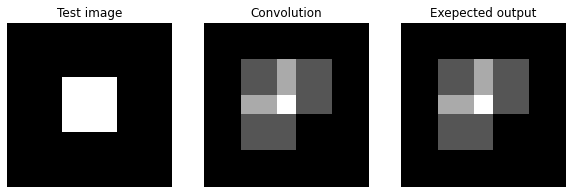

In [61]:
from filters import conv_nested

# Simple convolution kernel.
kernel = np.array(
[
    [1,0,1],
    [0,0,0],
    [1,0,0]
])

# Create a test image: a white square in the middle
test_img = np.zeros((9, 9))
test_img[3:6, 3:6] = 1

# Run your conv_nested function on the test image
test_output = conv_nested(test_img, kernel)

# Build the expected output
expected_output = np.zeros((9, 9))
expected_output[2:7, 2:7] = 1
expected_output[5:, 5:] = 0
expected_output[4, 2:5] = 2
expected_output[2:5, 4] = 2
expected_output[4, 4] = 3

# Plot the test image
plt.subplot(1,3,1)
plt.imshow(test_img)
plt.title('Test image')
plt.axis('off')

# Plot your convolved image
plt.subplot(1,3,2)
plt.imshow(test_output)
plt.title('Convolution')
plt.axis('off')

# Plot the exepected output
plt.subplot(1,3,3)
plt.imshow(expected_output)
plt.title('Exepected output')
plt.axis('off')
plt.show()

# Test if the output matches expected output
assert np.max(test_output - expected_output) < 1e-10, "Your solution is not correct."

Now let's test your `conv_nested` function on a real image.

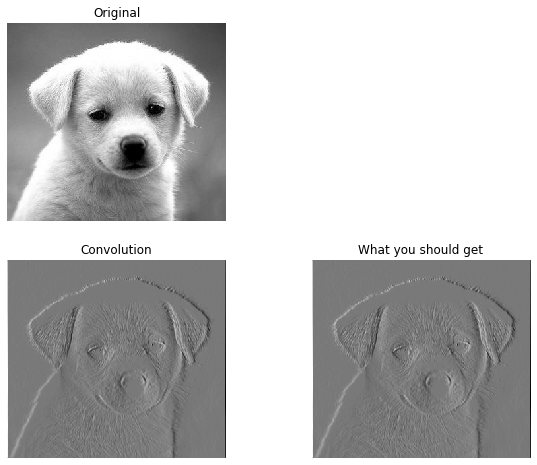

In [62]:
from filters import conv_nested

# Simple convolution kernel.
# Feel free to change the kernel to see different outputs.
kernel = np.array(
[
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])

out = conv_nested(img, kernel)

# Plot original image
plt.subplot(2,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')

# Plot your convolved image
plt.subplot(2,2,3)
plt.imshow(out)
plt.title('Convolution')
plt.axis('off')

# Plot what you should get
solution_img = io.imread('convoluted_dog.jpg', as_gray=True)
plt.subplot(2,2,4)
plt.imshow(solution_img)
plt.title('What you should get')
plt.axis('off')


plt.show()

Let us implement a more efficient version of convolution using array operations in numpy. As shown in the lecture, a convolution can be considered as a sliding window that computes sum of the pixel values weighted by the flipped kernel. The faster version will i) zero-pad an image, ii) flip the kernel horizontally and vertically, and iii) compute weighted sum of the neighborhood at each pixel.

First, implement the function **`zero_pad`** in **`filters.py`**.


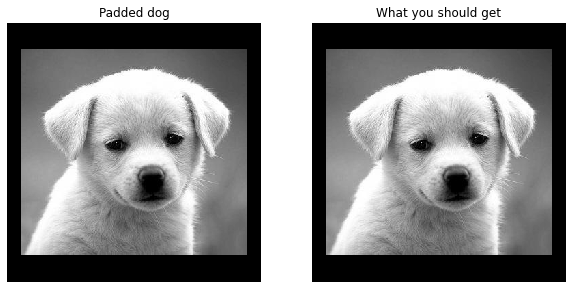

In [63]:
from filters import zero_pad

pad_width = 20 # width of the padding on the left and right
pad_height = 40 # height of the padding on the top and bottom

padded_img = zero_pad(img, pad_height, pad_width)

# Plot your padded dog
plt.subplot(1,2,1)
plt.imshow(padded_img)
plt.title('Padded dog')
plt.axis('off')

# Plot what you should get
solution_img = io.imread('padded_dog.jpg', as_gray=True)
plt.subplot(1,2,2)
plt.imshow(solution_img)
plt.title('What you should get')
plt.axis('off')

plt.show()

Next, complete the function **`conv_fast`** in **`filters.py`** using `zero_pad`. Run the code below to compare the outputs by the two implementations. `conv_fast` should run significantly faster than `conv_nested`.  
Depending on your implementation and computer, `conv_nested` should take a few seconds and `conv_fast` should be around 5 times faster.

conv_nested: took 6.424262 seconds.
conv_fast: took 1.308566 seconds.


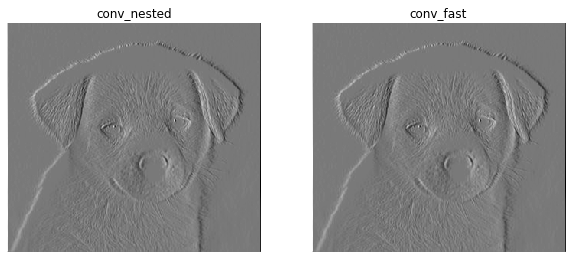

In [64]:
from filters import conv_fast

t0 = time()
out_fast = conv_fast(img, kernel)
t1 = time()
out_nested = conv_nested(img, kernel)
t2 = time()

# Compare the running time of the two implementations
print("conv_nested: took %f seconds." % (t2 - t1))
print("conv_fast: took %f seconds." % (t1 - t0))

# Plot conv_nested output
plt.subplot(1,2,1)
plt.imshow(out_nested)
plt.title('conv_nested')
plt.axis('off')

# Plot conv_fast output
plt.subplot(1,2,2)
plt.imshow(out_fast)
plt.title('conv_fast')
plt.axis('off')

# Make sure that the two outputs are the same
if not (np.max(out_fast - out_nested) < 1e-10):
    print("Different outputs! Check your implementation.")

---
## Part 2: Cross-correlation

Cross-correlation of two 2D signals $f$ and $g$ is defined as follows:
$$(f\star{g})[m,n]=\sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[i,j]\cdot g[i-m,j-n]$$

### 2.1 Template Matching with Cross-correlation (12 points)
Suppose that you are a clerk at a grocery store. One of your responsibilites is to check the shelves periodically and stock them up whenever there are sold-out items. You got tired of this laborious task and decided to build a computer vision system that keeps track of the items on the shelf.

Luckily, you have learned in the Computer Vision class at Jacobs University that cross-correlation can be used for template matching: a template $g$ is multiplied with regions of a larger image $f$ to measure how similar each region is to the template.

The template of a product (`template.jpg`) and the image of shelf (`shelf.jpg`) is provided. We will use cross-correlation to find the product in the shelf.

Implement **`cross_correlation`** function in **`filters.py`** and run the code below.

*- Hint: you may use the `conv_fast` function you implemented in the previous question.*

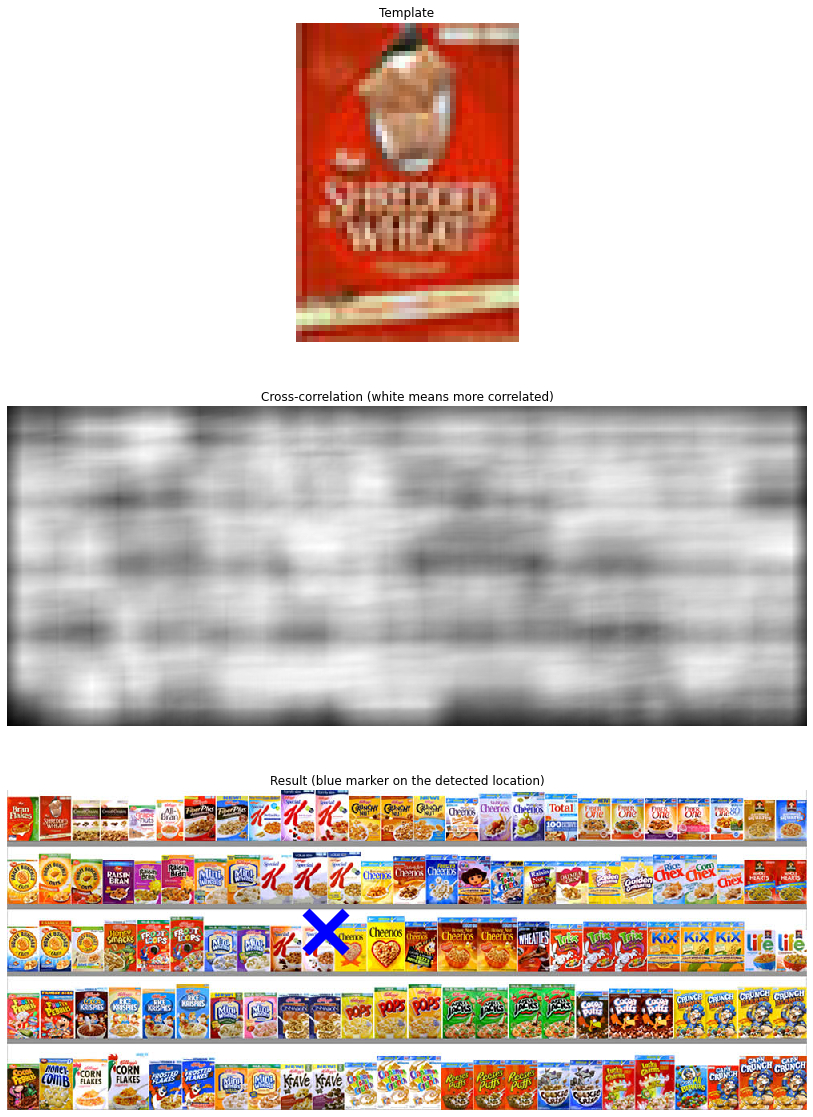

In [65]:
from filters import cross_correlation

# Load template and image in grayscale
img = io.imread('shelf.jpg')
img_grey = io.imread('shelf.jpg', as_gray=True)
temp = io.imread('template.jpg')
temp_grey = io.imread('template.jpg', as_gray=True)

# Perform cross-correlation between the image and the template
out = cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y,x = (np.unravel_index(out.argmax(), out.shape))

# Display product template
plt.figure(figsize=(25,20))
plt.subplot(3, 1, 1)
plt.imshow(temp)
plt.title('Template')
plt.axis('off')

# Display cross-correlation output
plt.subplot(3, 1, 2)
plt.imshow(out)
plt.title('Cross-correlation (white means more correlated)')
plt.axis('off')

# Display image
plt.subplot(3, 1, 3)
plt.imshow(img)
plt.title('Result (blue marker on the detected location)')
plt.axis('off')

# Draw marker at detected location
plt.plot(x, y, 'bx', ms=40, mew=10)
plt.show()


#### Interpretation
How does the output of cross-correlation filter look? Was it able to detect the product correctly? Explain what problems there might be with using a raw template as a filter.

**Your Answer:** *Write your solution in this markdown cell.*

The output is a blurred version of the shelf. No, it was not able to detect the product correctly. One reason for this incorrect result could be the fact that the shelf had too many colors for an accurate comparison and another is that since the gray picture of the product on the shelf image is much smaller than the template image, it is again harder to establish an accurate result.

---
### 2.2 Zero-mean cross-correlation (6 points)
A solution to this problem is to subtract the mean value of the template so that it has zero mean.

Implement **`zero_mean_cross_correlation`** function in **`filters.py`** and run the code below.

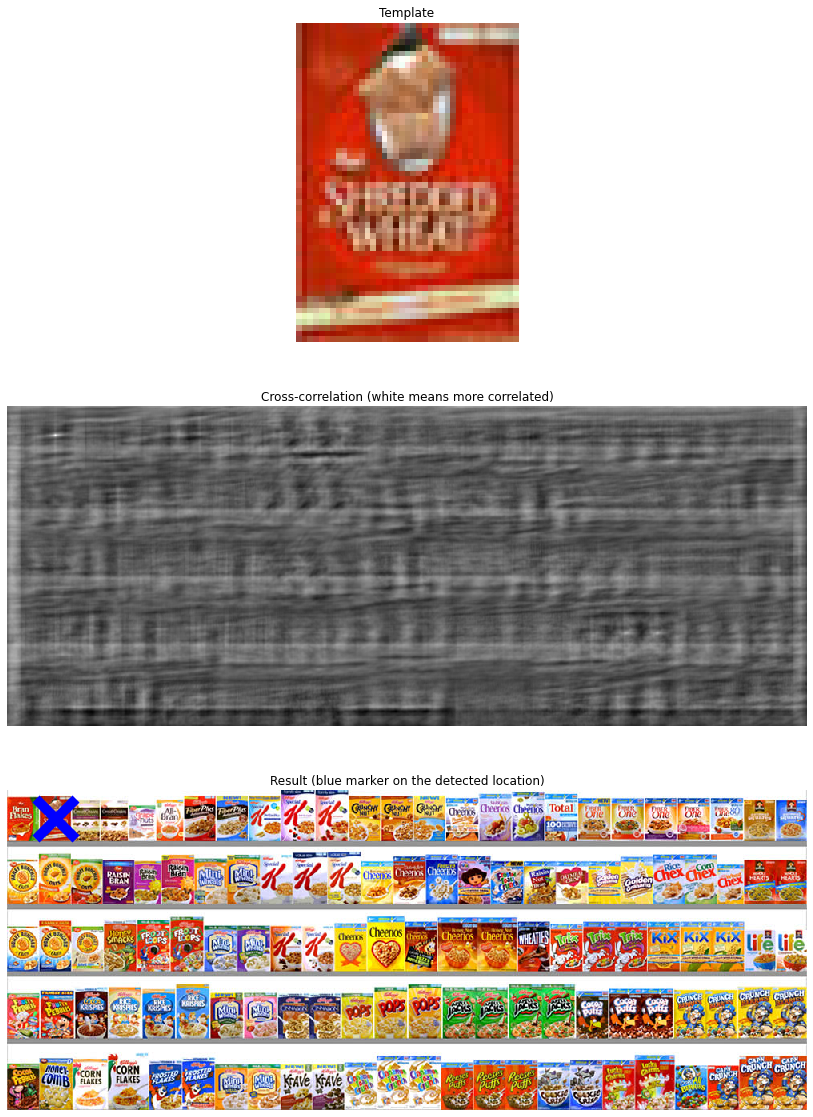

In [66]:
from filters import zero_mean_cross_correlation

# Perform cross-correlation between the image and the template
out = zero_mean_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y,x = (np.unravel_index(out.argmax(), out.shape))

# Display product template
plt.figure(figsize=(30,20))
plt.subplot(3, 1, 1)
plt.imshow(temp)
plt.title('Template')
plt.axis('off')

# Display cross-correlation output
plt.subplot(3, 1, 2)
plt.imshow(out)
plt.title('Cross-correlation (white means more correlated)')
plt.axis('off')

# Display image
plt.subplot(3, 1, 3)
plt.imshow(img)
plt.title('Result (blue marker on the detected location)')
plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'bx', ms=40, mew=10)
plt.show()


You can also determine whether the product is present with appropriate scaling and thresholding.

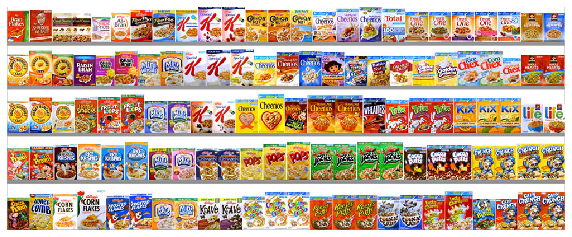

The product is on the shelf


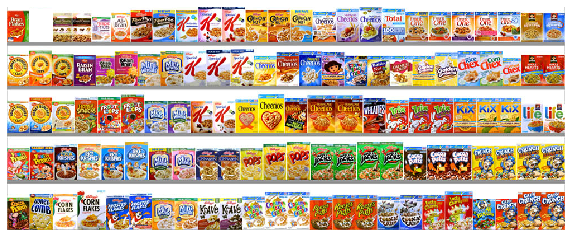

The product is not on the shelf


In [67]:
def check_product_on_shelf(shelf, product):
    out = zero_mean_cross_correlation(shelf, product)
    
    # Scale output by the size of the template
    out = out / float(product.shape[0]*product.shape[1])
    
    # Threshold output (this is arbitrary, you would need to tune the threshold for a real application)
    out = out > 0.025
    
    if np.sum(out) > 0:
        print('The product is on the shelf')
    else:
        print('The product is not on the shelf')

# Load image of the shelf without the product
img2 = io.imread('shelf_soldout.jpg')
img2_grey = io.imread('shelf_soldout.jpg', as_gray=True)

plt.imshow(img)
plt.axis('off')
plt.show()
check_product_on_shelf(img_grey, temp_grey)

plt.imshow(img2)
plt.axis('off')
plt.show()
check_product_on_shelf(img2_grey, temp_grey)

---
### 2.3 Normalized Cross-correlation (12 points)
One day the light near the shelf goes out and the product tracker starts to malfunction. The `zero_mean_cross_correlation` is not robust to change in lighting condition. The code below demonstrates this.

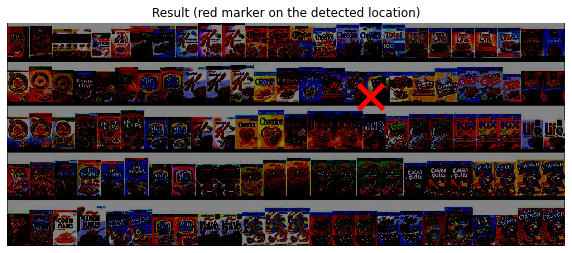

In [45]:
from filters import normalized_cross_correlation

# Load image
img = io.imread('shelf_dark.jpg')
img_grey = io.imread('shelf_dark.jpg', as_gray=True)

# Perform cross-correlation between the image and the template
out = zero_mean_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y,x = (np.unravel_index(out.argmax(), out.shape))

# Display image
plt.imshow(img)
plt.title('Result (red marker on the detected location)')
plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'rx', ms=25, mew=5)
plt.show()

A solution is to normalize the pixels of the image and template at every step before comparing them. This is called **normalized cross-correlation**.

The mathematical definition for normalized cross-correlation of $f$ and template $g$ is:
$$(f\star{g})[m,n]=\sum_{i,j} \frac{f[i,j]-\overline{f_{m,n}}}{\sigma_{f_{m,n}}} \cdot \frac{g[i-m,j-n]-\overline{g}}{\sigma_g}$$

where:
- $f_{m,n}$ is the patch image at position $(m,n)$
- $\overline{f_{m,n}}$ is the mean of the patch image $f_{m,n}$
- $\sigma_{f_{m,n}}$ is the standard deviation of the patch image $f_{m,n}$ 
- $\overline{g}$ is the mean of the template $g$
- $\sigma_g$ is the standard deviation of the template $g$

Implement **`normalized_cross_correlation`** function in **`filters.py`** and run the code below.

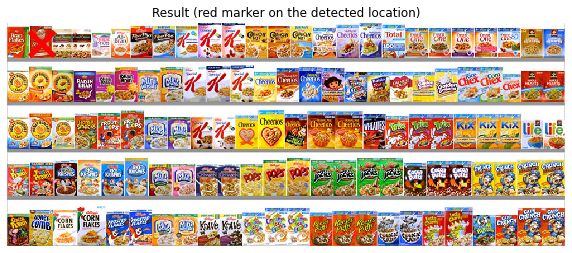

In [68]:
from filters import normalized_cross_correlation

# Perform normalized cross-correlation between the image and the template
out = normalized_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y,x = (np.unravel_index(out.argmax(), out.shape))

# Display image
plt.imshow(img)
plt.title('Result (red marker on the detected location)')
plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'rx', ms=25, mew=5)
plt.show()

## Part 3: Separable Filters

### 3.1 Theory (10 points)
Consider an $M_1\times{N_1}$ image $I$ and an $M_2\times{N_2}$ filter $F$. A filter $F$ is **separable** if it can be written as a product of two 1D filters: $F=F_1F_2$.

For example,
$$F=
\begin{bmatrix}
1 & -1 \\
1 & -1
\end{bmatrix}
$$
can be written as a matrix product of
$$F_1=
\begin{bmatrix}
1  \\
1
\end{bmatrix},
F_2=
\begin{bmatrix}
1 & -1
\end{bmatrix}
$$
Therefore $F$ is a separable filter.

Prove that for any separable filter $F=F_1F_2$,
$$I*F=(I*F_1)*F_2$$

**Your Answer:** *Write your solution in this markdown cell. Please write your equations in [LaTex equations](http://jupyter-notebook.readthedocs.io/en/latest/examples/Notebook/Typesetting%20Equations.html).*

Since F is seperable,

\begin{equation*}
    F[i,j] = F_1[i] \cdot F_2[j]
\end{equation*}

Next, using the definition for convolution:


\begin{equation*}
    (I * F)[m,n] =  \sum_{i=-\infty}^\infty    \sum_{j=-\infty}^\infty I[i,j] \cdot F[m-i,n-j]
\end{equation*}

\begin{equation*}
    =  \sum_{i=-\infty}^\infty \sum_{j=-\infty}^\infty I[i,j] \cdot F_1[m-i] \cdot F_2[n-j]
\end{equation*}

\begin{equation*}
    =  \sum_{i=-\infty}^\infty I[i,j] \cdot F_1[m-i] \sum_{j=-\infty}^\infty F_2[n-j]
\end{equation*}

\begin{equation*}
    =  (I * F_1) \cdot \sum_{j=-\infty}^\infty F_2[n-j]
\end{equation*}

\begin{equation*}
    =  (I * F_1) * F_2
\end{equation*}

Hence proved.

